# Demo Manipulation

## Export Data

Feature extraction and matching work directly from images, so export these first.

In [1]:
%load_ext autoreload
%autoreload 2
import json
from pathlib import Path
from tqdm.notebook import tqdm  # notebook-friendly progress bars

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image, plot_keypoints
from hloc.utils import viz_3d

In [2]:
from flow_control.demo.playback_env_servo import PlaybackEnvServo
from flow_control.localize.hloc_utils import export_images_by_parts

# root_dir = Path("/home/argusm/CLUSTER/robot_recordings/flow/recombination/2023-01-24")
root_dir = Path("/home/argusm/Desktop/Demonstrations/2023-01-24")
# root_dir = Path("/home/nayakab/Desktop/Courses/WS2022/Project/cluster/")
parts_fn = root_dir / 'parts.json'
hloc_root = root_dir.parent / ( str(root_dir.name) + '_hloc')

mapping_dir = hloc_root / 'mapping'
outputs = hloc_root / 'outputs'
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features_path = outputs / 'features.h5'
matches_path = outputs / 'matches.h5'
features_seg_path = outputs / 'features_seg.h5'

if parts_fn.is_file():
    with open(parts_fn) as f_obj:
        parts_references = json.load(f_obj)
        print("Succesfully loaded parts. --> Skip to ")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Succesfully loaded parts. --> Skip to 


In [3]:
from flow_control.localize.hloc_utils import to_hloc_ref
with open(parts_fn) as f_obj:
    tmp = json.load(f_obj)

parts_references = {}
parts_references['locate'] = [to_hloc_ref(k,v['locate'][0]) for k,v in tmp.items()]

In [4]:
!rm -rf $outputs
!rm -rf $mapping_dir
parts_references = export_images_by_parts(root_dir, parts_fn, mapping_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:25<00:00,  3.48it/s]


In [5]:
references_all = [ref for ref_part in parts_references.values() for ref in ref_part]
references_files = sorted([p.relative_to(hloc_root).as_posix() for p in (hloc_root / 'mapping/').iterdir()])
assert len(set(references_all)-set(references_files)) == 0
references = parts_references['locate']

30 mapping images


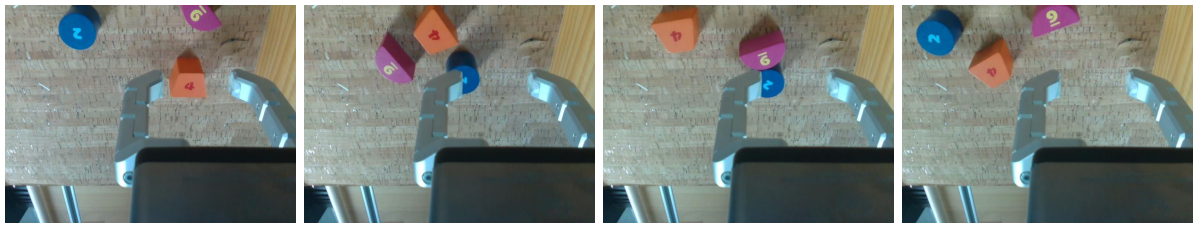

In [6]:
print(len(references), "mapping images")
plot_images([read_image(hloc_root / r) for r in references[:4]], dpi=50)

In [7]:
from flow_control.localize.hloc_utils import save_features_seg


feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

extract_features.main(feature_conf, hloc_root, image_list=references_all, feature_path=features_path)
save_features_seg(root_dir, features_seg_path, features_path, references_all)

pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features_path, matches=matches_path)

[2023/05/05 14:17:11 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.91 GiB total capacity; 1.83 MiB already allocated; 11.56 MiB free; 2.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from hloc.utils.io import get_keypoints

num_images = 4
plot_images([read_image(hloc_root / r) for r in references[:num_images]], dpi=75)
plot_keypoints([get_keypoints(features_path, r) for r in references[:num_images]], colors='lime', ps=4)

## Load Match Database

hloc saves all features and matches in a SQL database, so reading these is the easiest option.

In [ ]:
from hloc.utils.io import get_keypoints
from flow_control.localize.hloc_utils import get_segmentation

name0 = references[1]
kps0, noise0 = get_keypoints(features_path, name0, return_uncertainty=True)
kps0_seg, noise0 = get_keypoints(features_seg_path, name0, return_uncertainty=True)
seg = get_segmentation(root_dir, name0)

plot_images([read_image(hloc_root / r) for r in [name0, ]]+[seg], dpi=75)
plot_keypoints([kps0, kps0_seg], colors='lime', ps=4)

In [ ]:
from hloc.utils.io import get_matches
from flow_control.localize.hloc_utils import kp_seg_filter

name_q = references[1]
name_d = references[3]

matches, scores = get_matches(matches_path, name_q, name_d)
kps_q, noise_q = get_keypoints(features_path, name_q, return_uncertainty=True)
kps_d, noise_d = get_keypoints(features_path, name_d, return_uncertainty=True)
kps_q_match = kps_q[matches[:, 0]]
kps_d_match = kps_d[matches[:, 1]]

#%prun in_seg = kp_seg_filter_pb(kps_d_match, name_d)
in_seg = kp_seg_filter(kps_d_match, name_d, features_seg_path)

print("in_seg", in_seg)
print(kps_d_match[in_seg].shape)

kps_q_seg = kps_q_match[in_seg]
kps_d_seg = kps_d_match[in_seg]

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

import ipdb

with open(parts_fn, 'r') as f_obj:
    part_info = json.load(f_obj)

def get_tcp_position_orn(demo_dir, frame_index):
    arr = np.load(os.path.join(demo_dir, f"frame_{frame_index:06d}.npz"),allow_pickle=True)
    state = arr["robot_state"].item()
    return state["tcp_pos"], state['tcp_orn']

def get_tcp_position_at_grasp(name_q):
    tmp = name_q.strip().split('/')[1]
    rec_name = tmp.split('_')[0]
    
    rec_path = os.path.join(root_dir, rec_name)
    gripper_close_idx = part_info[rec_name]['insert'][0]
    
    pos, orn = get_tcp_position_orn(rec_path, gripper_close_idx)
    return pos, orn

def compute_distance(name_q, name_d):
    pos_q, orn_q = get_tcp_position_at_grasp(name_q)
    pos_d, orn_d = get_tcp_position_at_grasp(name_d)
    
    orn_q = R.from_quat(orn_q)
    orn_d = R.from_quat(orn_d)
    
    orn_d = orn_d.inv().as_matrix()
    orn_q = orn_q.as_matrix()

    pos_dist = np.linalg.norm(pos_q - pos_d)
    
    orn_dist = orn_q @ orn_d
    orn_dist = R.from_matrix(orn_dist)
    
    error_mag = np.linalg.norm(orn_dist.as_rotvec(degrees=True))
    
#     ipdb.set_trace()
    
    return pos_dist, error_mag

In [ ]:
from hloc.visualization import plot_matches
from flow_control.localize.hloc_utils import get_playback, align_pointclouds
import matplotlib.pyplot as plt
import os
import json
    
def find_best_demo(name_q, query_cam, references):
    results = {}
    for name_d in tqdm(references):
        if name_q == name_d:
            continue
        
        res = align_pointclouds(root_dir, matches_path, features_path, features_seg_path,
                                           name_q, name_d, query_cam=query_cam)
        if res is None:
            continue
            
        res['trf_est'] = res['trf_est']
        res['num_inliers'] = int(res['num_inliers'])
        res['num_candidates'] = int(res['num_candidates'])
        res['in_score'] = float(res['num_candidates'])
        
        results[name_d] = res
#         plot_images([read_image(hloc_root / r) for r in [name_q, name_d]], dpi=75)
#         plot_matches(res["kps_q"], res["kps_d"], a=0.1)
#         plt.show()

    results = {k: v for k, v in results.items() if v is not None}
    results_sorted = sorted(results.items(), key=lambda t: -t[1]["num_inliers"])
    
    name_d_best = results_sorted[0][0]
    res_best = results_sorted[0][1]
    return name_d_best, res_best, results

hloc_pos_errors = []
hloc_orn_errors = []


for idx in range(len(references)):
    name_q = references[idx]
    pb, frame_index = get_playback(root_dir, name_q)
    query_cam = pb[frame_index].cam

    #%prun -D program.prof 
    name_d_best, res_best, results = find_best_demo(name_q, query_cam, references)
    print(name_q, name_d_best)
    
    pos_err, orn_err = compute_distance(name_q, name_d_best)
    
    hloc_pos_errors.append(pos_err)
    hloc_orn_errors.append(orn_err)
    
    trf_best = res_best["trf_est"]

    plot_images([read_image(hloc_root / r) for r in [name_q, name_d_best]], dpi=75)
    plot_matches(res_best["kps_q"], res_best["kps_d"], a=0.1)

In [ ]:
# from scipy import stats

# res = stats.cumfreq(distances, numbins=30, defaultreallimits=(0.0, 0.15))
# x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
# plt.plot(x * 1000, res.cumcount / len(distances))
# plt.xlabel("Error (mm)")
# plt.ylabel("Samples (%)")

In [ ]:
# for name_q in references:
#     name_d_best, res_best = find_best_demo(name_q, references)
#     print(name_q, name_d_best)

## Visual Similarity 

In [ ]:
from sklearn.preprocessing import minmax_scale

recordings = sorted([root_dir / f for f in os.listdir(root_dir)])
recordings = recordings[:-1]

# Load Servoing Module
from flow_control.servoing.module import ServoingModule
control_config = dict(mode="pointcloud-abs-rotz", threshold=0.40)
servo_module = ServoingModule(recordings[0], control_config=control_config,
                              start_paused=False, flow_module='RAFT')

def similarity_from_reprojection(live_rgb, demo_rgb, demo_mask, return_images=False):
    # evaluate the similarity via flow reprojection error
    flow = servo_module.flow_module.step(demo_rgb, live_rgb)
    warped = servo_module.flow_module.warp_image(live_rgb / 255.0, flow)
    error = np.linalg.norm((warped - (demo_rgb / 255.0)), axis=2) * demo_mask
    error = error.sum() / demo_mask.sum()
    mean_flow = np.linalg.norm(flow[demo_mask],axis=1).mean()
    if return_images:
        return error, mean_flow, flow, warped
    return error, mean_flow

sim_scores = np.ones((len(recordings), len(recordings)))  # lower is better
mean_flows = np.zeros((len(recordings), len(recordings)))

demo_good = [True for rec in recordings]

bad_pair_arr = np.zeros((len(recordings), len(recordings)), dtype=bool)
for idx in np.where(np.array(demo_good) == False)[0]:
    bad_pair_arr[:,idx] = True
    bad_pair_arr[idx,:] = True
bad_pair_arr += np.eye(len(recordings), len(recordings), dtype=bool)

good_pairs = list(zip(*np.where(bad_pair_arr==False)))

for live_i, demo_i in tqdm(good_pairs):
    live_rgb = read_image(hloc_root / references[live_i])

    demo_rgb =  read_image(hloc_root / references[demo_i])
    demo_mask = get_segmentation(root_dir, references[demo_i])
    
    error, mean_flow = similarity_from_reprojection(live_rgb.copy(), demo_rgb.copy(), demo_mask.copy())
    assert error <= 1.0
    sim_scores[demo_i, live_i] = error
    mean_flows[demo_i, live_i] = mean_flow


sim_l = sim_scores[demo_good]
mean_flows_l = mean_flows[demo_good]

sim_scores_norm = np.ones(sim_scores.shape)
w = .5
sim_scores_norm[demo_good] = np.mean((1*minmax_scale(sim_l), w*minmax_scale(mean_flows_l)),axis=0)/(1+w)

In [ ]:
vs_pos_errors = []
vs_orn_errors = []

best_demo_idx = np.argmin(sim_scores_norm, axis=0)

for idx in range(len(recordings)):
    name_q = references[idx]
    name_d_best = references[best_demo_idx[idx]]
    
    pos_err, orn_err = compute_distance(name_q, name_d_best)
    vs_pos_errors.append(pos_err)
    vs_orn_errors.append(orn_err)

## R3M 

In [ ]:
from r3m import load_r3m
import torchvision.transforms as T
import torch
import ipdb

transform = T.Compose([T.ToTensor()])

def get_r3m_embeddings(playbacks, transform=None, device='cuda', masked=False):
    embeddings = []

    r3m = load_r3m("resnet50")
    r3m.eval()
    r3m.to(device)
    
    with torch.no_grad():
        
        for pb in playbacks:
            im = pb[18].cam.get_image()[0]
            
            if masked:
                mask = pb.get_fg_mask()
                mask = mask[..., np.newaxis].repeat(3, axis=2)
                im = im * mask
                
            im = transform(im)

            im = im.unsqueeze(0).cuda()
            embeddings.append(r3m(im * 255.0))
        
        embeddings = torch.cat(embeddings)
    
    embeddings = embeddings.detach().cpu().numpy()
    
    return embeddings

playbacks = [PlaybackEnvServo(rec, load='keep') for rec in recordings[:]]

embeddings_with_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=True)
embeddings_without_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=False)

In [ ]:
from scipy.spatial import distance

r3m_sim_scores_masked = np.ones(bad_pair_arr.shape) * 10.0  # lower is better
r3m_sim_scores_no_mask = np.ones(bad_pair_arr.shape) * 10.0

for live_i, demo_i in tqdm(good_pairs):
    live_embedding = embeddings_without_mask[live_i, :] 
    
    demo_embedding = embeddings_without_mask[demo_i, :]
    demo_embedding_masked = embeddings_with_mask[demo_i, :]
    
    error_masked = np.linalg.norm(demo_embedding_masked - live_embedding)
    error_no_mask = np.linalg.norm(demo_embedding - live_embedding)

    r3m_sim_scores_masked[demo_i, live_i] = error_masked    
    r3m_sim_scores_no_mask[demo_i, live_i] = error_no_mask

In [ ]:
r3m_masked_pos_errors = []
r3m_masked_orn_errors = []

r3m_unmasked_pos_errors = []
r3m_unmasked_orn_errors = []

best_demo_idx_masked = np.argmin(r3m_sim_scores_masked, axis=0)
best_demo_idx_no_mask = np.argmin(r3m_sim_scores_no_mask, axis=0)

for idx in range(len(recordings)):
    name_q = references[idx]
    
    name_d_best_masked = references[best_demo_idx_masked[idx]]
    name_d_best_no_mask = references[best_demo_idx_no_mask[idx]]
    
    pos_err_m, orn_err_m = compute_distance(name_q, name_d_best_masked)
    pos_err_nm, orn_err_nm = compute_distance(name_q, name_d_best_no_mask)
    
    r3m_masked_pos_errors.append(pos_dist_m)
    r3m_masked_orn_errors.append(orn_dist_m)
    
    r3m_unmasked_pos_errors.append(pos_dist_nm)
    r3m_unmasked_orn_errors.append(orn_dist_nm)

## Plotting 

In [ ]:
# Orientation Errors
from scipy import stats

max_orn_error = max(np.max(vs_orn_errors), np.max(hloc_orn_err), 
                    np.max(r3m_masked_orn_errors), np.max(r3m_unmasked_orn_errors))

res = stats.cumfreq(vs_orn_errors, numbins=30, defaultreallimits=(0.0, max_orn_error))
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x, res.cumcount / len(vs_orn_errors), label='VS')

res = stats.cumfreq(hloc_orn_err, numbins=30, defaultreallimits=(0.0, max_orn_error))
plt.plot(x, res.cumcount / len(hloc_orn_err), label='HLOC')

res = stats.cumfreq(r3m_masked_orn_errors, numbins=30, defaultreallimits=(0.0, max_orn_error))
plt.plot(x, res.cumcount / len(r3m_masked_orn_errors), label='R3M_masked')

res = stats.cumfreq(r3m_unmasked_orn_errors, numbins=30, defaultreallimits=(0.0, max_orn_error))
plt.plot(x, res.cumcount / len(r3m_unmasked_orn_errors), label='R3M_no_mask')

plt.xlabel("Error (Mag)")
plt.ylabel("Samples (%)")
plt.legend()

plt.show()

In [ ]:
from scipy import stats

max_dist_error = max(np.max(vs_pos_errors), np.max(hloc_pos_errors), 
                    np.max(r3m_masked_pos_errors), np.max(r3m_unmasked_pos_errors))

res = stats.cumfreq(vs_pos_errors, numbins=30, defaultreallimits=(0.0, max_dist_error))
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
plt.plot(x * 1000, res.cumcount / len(vs_pos_errors), label='VS')

res = stats.cumfreq(hloc_pos_errors, numbins=30, defaultreallimits=(0.0, max_dist_error))
plt.plot(x * 1000, res.cumcount / len(hloc_pos_errors), label='HLOC')

res = stats.cumfreq(r3m_masked_pos_errors, numbins=30, defaultreallimits=(0.0, max_dist_error))
plt.plot(x * 1000, res.cumcount / len(r3m_masked_pos_errors), label='R3M_masked')

res = stats.cumfreq(r3m_unmasked_pos_errors, numbins=30, defaultreallimits=(0.0, max_dist_error))
plt.plot(x * 1000, res.cumcount / len(r3m_unmasked_pos_errors), label='R3M_no_mask')

plt.xlabel("Error (mm)")
plt.ylabel("Samples (%)")
plt.legend()

plt.show()

In [ ]:
import copy
import numpy as np
import open3d as o3d
from flow_control.localize.hloc_utils import get_pointcloud, get_segmented_pointcloud

def draw_registration_result(source_arr, target_arr, transformation, color="rgb"):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_arr[:, :3])
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_arr[:, :3])
    
    if color == "rgb":
        source.colors = o3d.utility.Vector3dVector(source_arr[:, 4:7] )
        target.colors = o3d.utility.Vector3dVector(target_arr[:, 4:7] )
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
    else:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
        
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    return source_temp, target_temp
    
pc_seg_q, bbox = get_segmented_pointcloud(name_q, root_dir=root_dir)
pc_seg_d, bbox = get_segmented_pointcloud(name_d_best, root_dir=root_dir)
pcd_q, pcd_d = draw_registration_result(pc_seg_q, pc_seg_d, trf_best)


In [ ]:
# Evaluate the ICP registration error (does not include color)
pcd_q = o3d.t.geometry.PointCloud(pc_seg_q[:, 0:3])
pcd_d = o3d.t.geometry.PointCloud(pc_seg_d[:, 0:3])
treg = o3d.t.pipelines.registration
max_correspondence_distance = 0.02
evaluation = treg.evaluate_registration(pcd_q, pcd_d,
                                        max_correspondence_distance, trf_best)
print("Fitness: ", evaluation.fitness)
print("Inlier RMSE: ", evaluation.inlier_rmse)

## Warp Demo Segmentation to Live

We don't have segmentation for the live views. In the case of trying to get a segmented pointcloud for the live view we could try using an estimated segmentation map which is warped from the demo frame. 

1. Transform Demo Pointcloud to get 'live' pointcloud 
2. Project pointcloud to get live segmentation mask
3. Create a 'live' pointcloud using live rgb and depth images, along with masked points
4. Computer ICP Metrics between demo pointcloud and the live pointcloud

In [ ]:
from flow_control.rgbd_camera import RGBDCamera

debug_plot = False

# Demo pointcloud
pc_seg_d, _ = get_segmented_pointcloud(name_d_best, root_dir=root_dir)
trf_demo_to_live = np.linalg.inv(trf_best)
pc_d = pc_seg_d[:, 0:4]
pc_live_transformed = trf_demo_to_live @ pc_d.T

pts0, pts1 = query_cam.project(pc_live_transformed)
masked_points = np.array([(x, y) for (x, y) in zip(pts1, pts0)])

if debug_plot:
    seg_q = get_segmentation(root_dir, name_q)
    seg_d = get_segmentation(root_dir, name_d_best)
    seg_w = np.zeros_like(seg_q)
    seg_w[pts1, pts0] = True
    tmp = np.stack([seg_q, seg_d, seg_w], axis=2)*255
    plot_images([tmp,])
    print("red: live, green: demo, blue: warped")
    
def to_o3d_pc(arr):
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(arr[:, :3])
    pc.colors = o3d.utility.Vector3dVector(arr[:, 4:7]/255.)
    return pc

rgb_image, depth_image = query_cam.get_image()
rgbd_cam = RGBDCamera(query_cam)
pc_live = rgbd_cam.generate_pointcloud(rgb_image, depth_image, masked_points)
#o3d.visualization.draw_geometries([to_o3d_pc(pc_live), to_o3d_pc(pc_seg_d)])

# compute ICP metrics
pcd_q = o3d.t.geometry.PointCloud(pc_live[:, 0:3])
pcd_d = o3d.t.geometry.PointCloud(pc_seg_d[:, 0:3])
treg = o3d.t.pipelines.registration
max_correspondence_distance = 0.02
evaluation = treg.evaluate_registration(pcd_q, pcd_d,
                                        max_correspondence_distance, trf_best)
print("Fitness: ", evaluation.fitness)
print("Inlier RMSE: ", evaluation.inlier_rmse)

# Localization (Live Inferences)

In [ ]:


from PIL import Image
def create_query_image(query_cam):
    query_dir = hloc_root / "query"
    Path(query_dir).mkdir(parents=True, exist_ok=True)
    image_path_query = query_dir / "live.jpg"
    image_arr = query_cam.get_image()[0]
    Image.fromarray(image_arr).save(image_path_query)
    return image_path_query.relative_to(hloc_root).as_posix()

name_q = references[0]
pb, frame_index = get_playback(root_dir, name_q)
query_cam = pb[frame_index].cam
query = create_query_image(query_cam)

references_live = [x for x in references if x != name_q]
extract_features.main(feature_conf, hloc_root, image_list=[query], feature_path=features_path, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_live)
match_features.main(matcher_conf, loc_pairs, features=features_path, matches=matches_path, overwrite=True)
name_d_best_live, res_best_live = find_best_demo(query, qery_cam, references_live)

print(name_q, name_d_best_live)
plot_images([read_image(hloc_root / r) for r in [name_q, name_d_best_live]], dpi=75)
plot_matches(res_best_live["kps_q"], res_best_live["kps_d"], a=0.1)

In [ ]:
%load_ext autoreload
%autoreload 2



In [ ]:
from flow_control.localize.hloc_utils import get_playback

name_q = selection_hloc.parts_references['locate'][0]
pb, frame_index = get_playback(root_dir, name_q)
query_cam = pb[frame_index].cam
name_best, res_best = selection_hloc.get_best_demo(query_cam)
print(name_best)

# Original File

In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [ ]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image, plot_keypoints
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [ ]:
images = Path('datasets/sacre_coeur')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

In [ ]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [ ]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True)

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
fig.show()